# Repo Introduction with A Simplified Retail Scenario

In [18]:
from hydra import compose, initialize
from omegaconf import OmegaConf
import logging
from collections import defaultdict
import tensorflow as tf

logging.basicConfig(level=logging.INFO)

from retail_agent.utils.trajectory_util import get_env, get_random_policy, get_one_trajectory, get_fixed_arm_policy
from retail_agent.utils.train_eval_util import get_last_time_step, prepare_trajectory
from retail_agent.agents import get_retail_agent
from retail_agent.utils.segment_util import segment_customer_by_price_sensitivity
from retail_agent.utils.metric_util import generate_evaluation_report, generate_segmented_evaluation_report
from retail_agent.utils.viz_util import gather_all_customer_report

# Overview

This notebook shows an example of how to use `RetailSynth-AgentSim` as a bandit environment to train a bandit agent. We pick a basic agent, LinUCB, as the starting point to prototype a training routine, and showcase the visualization toolkit. We use hydra to manage configurations for the whole experiment workflow.

We do not provide a detail commentary on the results contained in this notebook, as the environment here is very simplified. Interested readers should checkout the paper referenced in the README for a more detailed discussion.

In [2]:
with initialize(version_base=None, config_path="../tests/cfg"):
    config = compose(config_name="agent_training")
    config = OmegaConf.to_object(config)

In [3]:
# Quick walkthrough of the whole process
n_train_traj = 3
n_train_step = 50
n_eval_traj = 3
n_eval_step = 20

# Collect offline data
train_trajectories = []
train_synthesizer = []
last_time_step = []
for _ in range(n_train_traj):
    env = get_env(config)
    random_policy = get_random_policy(env)
    trajectory = get_one_trajectory(env, random_policy, n_train_step)
    train_trajectories.append(trajectory)
    train_synthesizer.append(env.synthesizer)
    last_time_step.append(get_last_time_step(trajectory))

# Train LinUCB agent
agent = get_retail_agent(agent_type="linear_ucb", time_step_spec=env.time_step_spec(), action_spec=env.action_spec(), config=config["agent"]["agent_params"])
train_trajectories = prepare_trajectory(train_trajectories)
loss = agent.train(train_trajectories)

# Evaluate LinUCB agent
eval_trajectories = []
for i in range(n_eval_traj):
    env = get_env(config, train_synthesizer[i])
    trajectory = get_one_trajectory(env, agent.policy, n_eval_step, last_time_step[i])
    eval_trajectories.append(trajectory)
report = generate_evaluation_report({"LinUCB": eval_trajectories}, window_length=5, product_category_mapping=train_synthesizer[0].product_category_mapping, n_arm=env.n_coupon_levels, coupon_unit=env.coupon_unit)

report.keys()

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/64313/miniconda3/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


dict_keys(['revenue_df', 'selected_arm_df', 'metric_df'])

## Environment

In this notebook, we are going to explore a simplified retail environment with 100 customers and 20 products from 3 categories.

In [4]:
env = get_env(config)

print("n_customer: ", env.synthesizer.n_customer)
print("n_product: ", env.synthesizer.n_product)
print("n_category: ", env.synthesizer.n_category)

n_customer:  100
n_product:  20
n_category:  3


**Observation space** is a dictionary containing 4 primitive features 
- `previous_transaction`
- `product_price`
- `marketing_feature`
- `observed_customer_product_feature`

and 5 derived features
- `avg_purchase_quantity`
- `avg_purchase_probability`
- `avg_purchase_price`
- `avg_redeemed_discount`
- `avg_purchase_discount`

In [5]:
env.observation_spec()

{'previous_transaction': BoundedTensorSpec(shape=(20,), dtype=tf.int32, name='previous_transaction', minimum=array(0, dtype=int32), maximum=array(2147483647, dtype=int32)),
 'product_price': BoundedTensorSpec(shape=(20,), dtype=tf.float32, name='product_price', minimum=array(0., dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'marketing_feature': BoundedTensorSpec(shape=(), dtype=tf.float32, name='marketing_feature', minimum=array(0., dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'observed_customer_product_feature': BoundedTensorSpec(shape=(20,), dtype=tf.float32, name='observed_customer_product_feature', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'avg_purchase_quantity': BoundedTensorSpec(shape=(), dtype=tf.float32, name='avg_purchase_quantity', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'avg_purchase_probability': BoundedTensorSpec(shape=(), dtype=tf.flo

**Action Space** contains the store-wide coupon the retailer offers to each customer. This scaler feature is an integer ranging from 0 to 2, representing the distinct coupon levels. 0 means no coupon, 1 means 5% off and 2 means 10% off.

In [6]:
env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32))

**Reward space** represents the money spent by each customer.

In [7]:
env.reward_spec()

BoundedTensorSpec(shape=(), dtype=tf.float32, name='reward', minimum=array(0., dtype=float32), maximum=array(3.4028235e+38, dtype=float32))

## Train LinUCB Agent

The LinUCB agent is a linear model that uses the Upper Confidence Bound (UCB) algorithm to balance exploration and exploitation. The agent will learn a linear model of reward distribution for each action and use the UCB algorithm to select the action with the highest expected reward.

We provide utility functions to collect offline training data using random policy. 

In [8]:
# Collect offline data
n_train_traj = 3
n_train_step = 50

train_trajectories = []
# store the training synthesizer and last time step of each trajectory
# to make sure the evaluation starts from the last time step of the training trajectory
train_synthesizer = []
last_time_step = []
for _ in range(n_train_traj):
    env = get_env(config)
    random_policy = get_random_policy(env)
    trajectory = get_one_trajectory(env, random_policy, n_train_step)
    train_trajectories.append(trajectory)
    train_synthesizer.append(env.synthesizer)
    last_time_step.append(get_last_time_step(trajectory))

All of our retail agents are implemented using `tf-agents`. We train LinUCB agent with offline data in one batch, but if you'd like to train agents with mini-batches for consideration of data size and computing resources, you can maintain a for loop of training epochs and monitor the training losses.

In [9]:
agent = get_retail_agent(
    agent_type="linear_ucb",  # specify the agent type
    time_step_spec=env.time_step_spec(),
    action_spec=env.action_spec(),
    config=config["agent"]["agent_params"],  # additional agent parameters you'd like to tune
)
train_trajectories = prepare_trajectory(train_trajectories)
loss = agent.train(train_trajectories)

## Evaluate LinUCB Agent

We will compare the trained LinUCB policy with fixed arm policies and random policy to illustrate our visualization toolkit.

In [10]:
def evaluate_policy(policy, n_eval_traj, n_eval_step, train_synthesizer, last_time_step):
    eval_trajectories = []
    for i in range(n_eval_traj):
        env = get_env(config, train_synthesizer[i])
        # make sure the evaluation starts from the last time step of the training trajectory
        trajectory = get_one_trajectory(env, policy, n_eval_step, last_time_step[i])
        eval_trajectories.append(trajectory)
    return eval_trajectories


evaluation_results = {}
evaluation_results["LinUCB"] = evaluate_policy(agent.policy, n_eval_traj, n_eval_step, train_synthesizer, last_time_step)
policy = get_random_policy(env)
evaluation_results["Random"] = evaluate_policy(policy, n_eval_traj, n_eval_step, train_synthesizer, last_time_step)
for arm_idx in range(env.n_coupon_levels):
    policy = get_fixed_arm_policy(env, arm_idx)
    evaluation_results[f"FixedArm_{arm_idx}"] = evaluate_policy(policy, n_eval_traj, n_eval_step, train_synthesizer, last_time_step)

report = generate_evaluation_report(evaluation_results, window_length=5, product_category_mapping=train_synthesizer[0].product_category_mapping, n_arm=env.n_coupon_levels, coupon_unit=env.coupon_unit)

In the report dictionary, we compute the following:
- `metric_df`: a data frame containing the primary objective (accumulated revenue) and secondary metrics (accumulated demand, customer retention, category penetration, and empirical discount) for all policies.
- `selected_arm_df`: a data frame containing the probability of each arm being chosen for all policies.
- `revenue_df`: a data frame containing the accumulated revenue for all policies across all time step in evaluation trajectories. 

In [11]:
report["metric_df"].head()

,accumulated_revenue,accumulated_demand,customer_retention,category_penetration,empirical_discount,agent
0,144.924103,60.0,0.13,0.60,0.022600,LinUCB
1,142.861084,58.0,0.13,0.58,0.023650,LinUCB
2,142.861084,58.0,0.13,0.58,0.023775,LinUCB
0,126.153328,58.0,0.20,0.58,0.048875,Random
1,136.501160,59.0,0.20,0.59,0.048925,Random


In [12]:
report["selected_arm_df"].head()

,arm,prob,agent
0,0,0.568667,LinUCB
1,1,0.395833,LinUCB
2,2,0.035500,LinUCB
0,0,0.341167,Random
1,1,0.325667,Random


In [13]:
report["revenue_df"].head()

,agent,revenue,timestep
0,LinUCB,9.350916,1
1,LinUCB,13.684719,2
2,LinUCB,15.397045,3
3,LinUCB,24.797962,4
4,LinUCB,27.797962,5


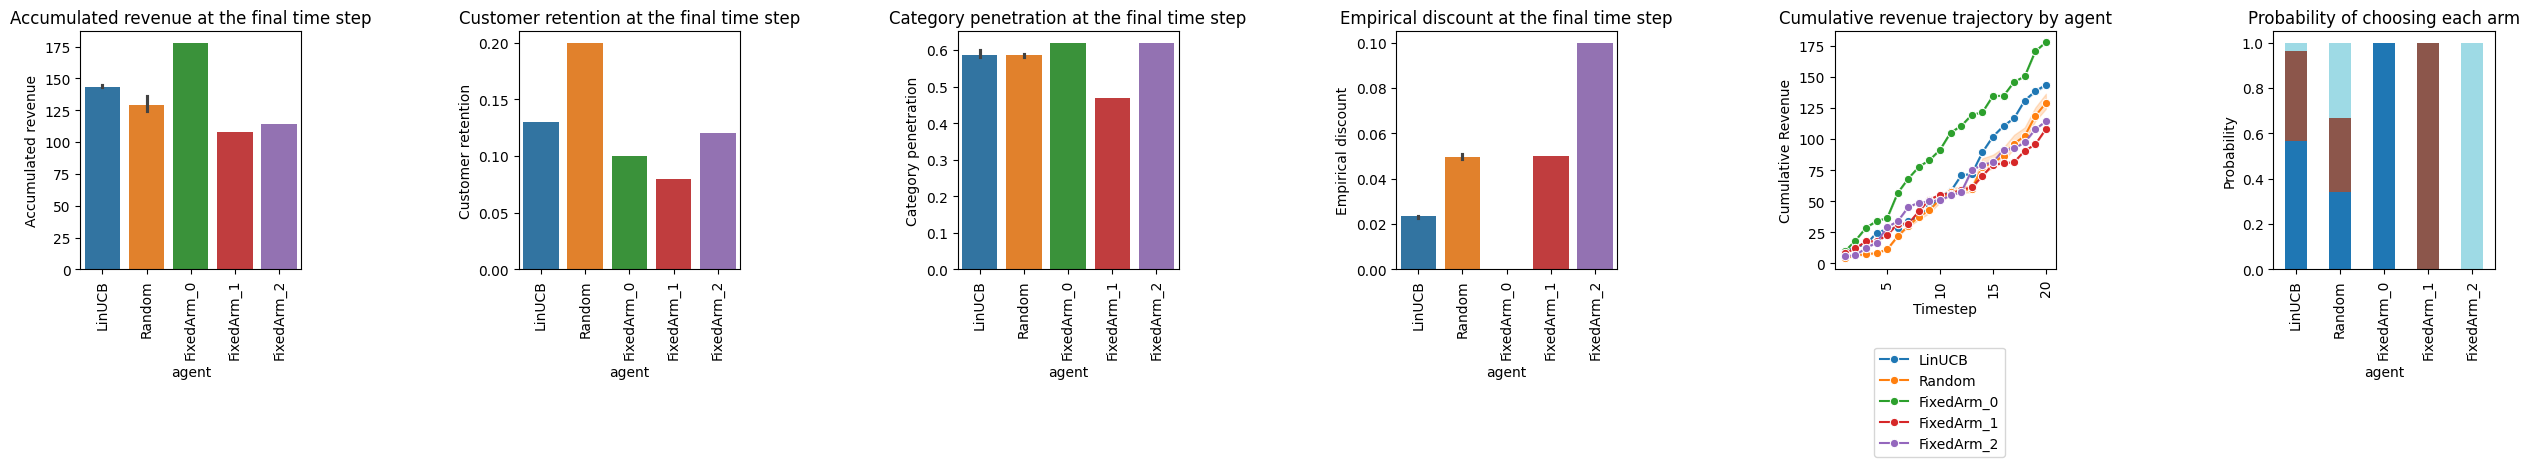

In [14]:
fig, ax = gather_all_customer_report(
    report,
    order=["LinUCB", "Random", "FixedArm_0", "FixedArm_1", "FixedArm_2"],
)
ax[-2].legend(bbox_to_anchor=(0.8, -0.3))

We can also compare the same suite of metrics on customer segments. We partition customers into 3 segments based on their price sensitivity coefficients.

In [19]:
n_segment = 2
customer_segment = segment_customer_by_price_sensitivity(train_synthesizer[0], n_segment)

segmented_evaluation_results = defaultdict(dict)
for segment in customer_segment.keys():
    for agent_name, traj in evaluation_results.items():
        seg_idx = customer_segment[segment]
        segmented_evaluation_results[segment][agent_name] = [tf.nest.map_structure(lambda x: tf.gather(x, seg_idx), t) for t in traj]

segmented_report = generate_segmented_evaluation_report(segmented_evaluation_results, window_length=5, product_category_mapping=train_synthesizer[0].product_category_mapping, n_arm=env.n_coupon_levels, coupon_unit=env.coupon_unit)

In [20]:
segmented_report["metric_df"].head()

,accumulated_revenue,accumulated_demand,customer_retention,category_penetration,empirical_discount,agent,segment
0,71.958824,24.0,0.12,0.48,0.02280,LinUCB,0
1,71.690796,24.0,0.12,0.48,0.02435,LinUCB,0
2,71.690796,24.0,0.12,0.48,0.02435,LinUCB,0
0,41.128017,22.0,0.16,0.44,0.04985,Random,0
1,48.718193,23.0,0.16,0.46,0.04910,Random,0
